Tarea: Analisis exploratorio con Topic Modeling
1. Extraer las noticias de una semana especifica en los medios de la region de Los Lagos
2. Extraer los topicos utilizando LDA
3. Identificar, por cada comuna, cuales son los topicos más importantes

* Entre 1000 y 2000 noticias está bien.

In [254]:
import spacy
import elasticsearch
from datetime import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
from pandasql import sqldf
from spacy.matcher import PhraseMatcher, Matcher
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models


def determineComuna(text):
    # print(type(text))
    if not isinstance(text, str):
        print("Warning: row.text is type ", type(text), text)
        return ""
    doc = nlp(text.lower())
    matches_cities = matcher(doc)
    rmatches = {}
    for match_id, start, end in matches_cities:
        span = doc[start:end]  # The matched span
        t = span.text
        if t in rmatches.keys():
            rmatches[t] += 1
        else:
            rmatches[t] = 1
        # print(t)
    # rmatches.items()
    rmatches = dict(sorted(rmatches.items(), key=lambda x: x[1], reverse=True))
    # print(rmatches)
    for key, val in rmatches.items():
        return key
    return ""


def dfUpdateComunas(df):
    res = df["text"].apply(determineComuna)
    df["comuna"] = res
    return df


nlp = spacy.load('es_core_news_sm')

IP = "search.sophia2.org"
PORT = 9200
USER = "elastic"
PASS = "dummy_elastic"

es = elasticsearch.Elasticsearch(
    f"http://{IP}:{PORT}",
    http_auth=(USER, PASS)
)

country = "chile"
from_ = "2021-06-01"
to_ = "2021-06-30"
media_outlets = ["elllanquihue", "elaustral", "laestrelladechiloe", "elheraldoaustral", "radiosago",
                 "elrepuertero", "elvacanudo", "elhuemul", "seminariolocal", "elquellonino", "elinsular",
                 "radiopudeto", "radioacogida", "elcalbucano", "segundos33",
                 "prensadelestuario", "fresiaahora", "soychiloe"]

comunas = [
    "ancud", "castro", "chonchi", "curaco de vélez", "dalcahue",
    "puqueldón", "queilén", "quemchi", "quellón", "quinchao", "calbuco",
    "cochamó", "fresia", "frutillar", "llanquihue", "los muermos", "maullín",
    "puerto montt", "puerto varas", "osorno", "puerto octay", "purranque",
    "puyehue", "río negro", "san juan de la costa", "san pablo", "chaitén",
    "futaleufú", "hualaihué", "palena",
]
""" for i, c in enumerate(comunas):
    comunas[i] = c.replace(" ", "_") """

for comuna in comunas:
    matcher.add(comuna, [nlp(comuna)])

headers = {'id_news': [], 'country': [], 'media_outlet': [],
           'url': [], 'title': [], 'text': [], 'date': [], 'comuna': []}

query = {
    "bool": {
        "filter": [
            {"range": {
                "date": {
                    "gte": from_,
                    "lt": to_
                }}},
            {"term":  {"country": country}},
            {"terms":  {"media_outlet": media_outlets}}
        ]
    }
}


In [255]:
FETFCH_DATA = False

if FETFCH_DATA:
    res = es.search(index="news", query=query, size=6000)
    print("Son %d noticias encontradas..." % res['hits']['total']['value'])

    df = pd.DataFrame(headers)

    for hit in res['hits']['hits']:
        id_news = hit['_source']['id_news']
        country = hit['_source']['country']
        media_outlet = hit['_source']['media_outlet']
        url = hit['_source']['url']
        title = hit['_source']['title']
        text = hit['_source']['text']
        date = hit['_source']['date']
        comuna = determineComuna(text)
        df.loc[len(df.index)] = [id_news, country, media_outlet,
                                 url, title, text, date, comuna]

    df = df.drop_duplicates(subset='url', keep='first')
    df = df[df["text"].isna() == False]
    df.to_csv("./data.csv")
else:
    df = pd.read_csv("./data.csv", index_col=0)
df


,id_news,country,media_outlet,url,title,text,date,comuna
0,21889455,chile,radiosago,https://www.radiosago.cl/seguridad-publica-y-c...,Seguridad Pública y Carabineros se reúnen con ...,"Gonzalo Reyes, Subdirector de Seguridad Públi...",2021-06-26,NaN
1,21889471,chile,radiosago,https://www.radiosago.cl/dictan-veredicto-cond...,Dictan veredicto condenatorio contra acusado d...,El Tribunal Oral en lo Penal de Puerto Montt ...,2021-06-27,puerto montt
2,21889476,chile,radiosago,https://www.radiosago.cl/puerto-montt-vencio-p...,Puerto Montt venció por 3 a 2 a Unión Española...,Esta jornada Deportes Puerto Montt y Unión Es...,2021-06-27,puerto montt
3,21889504,chile,radiosago,https://www.radiosago.cl/designan-a-fiscal-jef...,Designan a Fiscal Jefe de Puerto Montt en la i...,A través de un comunicado el Ministerio Públi...,2021-06-25,puerto montt
4,21889507,chile,radiosago,https://www.radiosago.cl/a-dos-queridos-period...,"A dos queridos periodistas: Adioses, entre la ...",Por Alejandro Gutiérrez Barría.Periodista puer...,2021-06-24,puerto montt
...,...,...,...,...,...,...,...,...
5594,47518202,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,Cierran causa por muerte de isleña cuyo cuerpo...,Ante el peso de las conclusiones tanatológicas...,2021-06-19,castro
5607,47518287,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,"Chiloé alcanzó el 83,7% de vacunación en prime...","A un 83,7% en primeras dosis y a un 68% con el...",2021-06-24,castro
5610,47518293,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,Ratifican cierre de causa por incendio y defen...,Sin el más mínimo reparo se concretó ayer el s...,2021-06-24,ancud
5611,47518295,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,"Core advierte ""retraso"" en entrega de hospital...",Adías de que el senador opositor Rabindranath ...,2021-06-24,ancud


In [5]:
# == Example Cell ==
sample_text = df.iloc[10]["text"]
print(sample_text)
print("Comuna:", determineComuna(sample_text))

Poco más de 200 familias se vieron afectadas durante la jornada de ayer luego que un camión tolva derribara al menos 10 postes del servicio eléctrico y telefonía en el sector de Mirasol, en Puerto Montt. El hecho se registró en la esquina de calle Sierra con Los Sauces en la población Mirasol, donde al menos diez los postes quedaron absolutamente inutilizados debido a que el camión siguió su trayectoria por al menos una cuadra sin que el conductor se percatara que llevaba la tolva levantada, arrastrando con ello los cables, los que iban cayendo sobre las rejas de las viviendas afectadas y también en la calzada. Cristián Arriagada, jefe de servicio al cliente de Saesa., detalló cómo se trabajó en terreno para restablecer el suministro, como asimismo pidió precaución y responsabilidad a los conductores de máquinas pesadas. En los últimos 12 meses 239 postes han sido dañados en distintos eventos, lo que equivale a 3 postes chocados cada dos días, se indicó desde la distribuidora. 
Comuna:

In [256]:
SAVE_DF = False
if SAVE_DF:
    df.to_csv("./data.csv")

In [257]:
result = sqldf("SELECT comuna,count(*) FROM df GROUP BY comuna ORDER BY count(*) DESC")
result

,comuna,count(*)
0,None,1123
1,puerto montt,310
2,osorno,260
3,castro,144
4,puerto varas,107
5,llanquihue,84
6,ancud,69
7,quellón,45
8,puyehue,27
9,chonchi,23


In [4]:
df = dfUpdateComunas(df)

In [299]:
testmatcher = Matcher(nlp.vocab)
""" for comuna in comunas:
    testmatcher.add(comuna, [nlp(comuna)]) """

testmatcher.add(
    "regiones_conocidas", [
        [{"NORM": "los"}, {"TEXT": {"REGEX": "[Ll]agos|[Rr]íos"}}],
    ])
testmatcher.add(
    "region", [
        [{"NORM": "región"}, {"NORM": "de"}],
    ])
testmatcher.add(
    "comuna", [
        [{"NORM": "comuna"}, {"NORM": "de"}]
    ])
testmatcher.add(
    "chile", [
        [{"TEXT": {"REGEX": "[Nn]aci[onal|ón]"}}],
        [{"NORM": "chile"}],
    ])
testmatcher.add(
    "localidades_comunes", [
        [{"NORM": "valdivia"}],
        [{"NORM": "chiloé"}],
        [{"NORM": "collipulli"}],
    ])
testmatcher.add(
    "cerca_ptomontt", [
        [{"NORM": "tenglo"}],
        [{"NORM": "panitao"}],
        [{"NORM": "arena"}],
        [{"NORM": "regional"}],
        [{"NORM": "comuna"}, {"TEXT": {"REGEX": "!de"}}],
        [{"NORM": "región"}, {"TEXT": {"REGEX": "!de"}}]
    ])

dic_prority = {
    "regiones_conocidas": 4,
    "region": 2,
    "comuna": 2,
    "chile": 1,
    "localidades_comunes": 3,
    "cerca_ptomontt": 5,
    "otros": 0,
}

dic_loc_comunes = {
    "valdivia": "valdivia",
    "chiloé": "castro",
    "collipulli": "la araucanía",
}


def determineComuna2(text):
    if not isinstance(text, str):
        print("Warning:", type(text), text)
        return ("", "")
    doc = nlp(text.lower())
    rawmatches = testmatcher(doc)
    rmatches = {}
    matches = []
    for match_id, a, b in rawmatches:
        match_tag = nlp.vocab.strings[match_id]
        matches.append([match_tag, a, b, dic_prority[match_tag]])

    matches = sorted(matches, key=lambda x: x[3], reverse=True)
    for match_tag, start, end, _ in matches:
        span = doc[start:end]  # The matched span
        t = span.text
        #match_tag = nlp.vocab.strings[match_id]

        """ "regiones_conocidas": 4,
        "region": 2,
        "comuna": 2,
        "chile": 1,
        "localidades_comunes": 3,
        "cerca_ptomontt": 5,
        "otros": 0, """

        #print(t)
        if match_tag == "regiones_conocidas":
            # Asumiré las noticias regionales para las capitales
            if "agos" in t:
                return "puerto montt"
            else:
                return "valdivia"
        elif match_tag == "cerca_ptomontt":
            return "puerto montt"
        elif match_tag in ["comuna", "region"] :
            if "de" in t:
                append_token = [t, doc[end].text]  # comuna de xxxx
                if doc[end].text in ["las", "los", "la", "el", "lo"]:  # comuna de los
                    end += 1
                    append_token.append(doc[end].text)  # comuna de los xxxx
                if doc[end].text in ["río"]:  # comuna de río
                    end += 1
                    append_token.append(doc[end].text)  # comuna de río xxxx
                return " ".join(append_token)
            else:
                return "puerto montt"  # Para casos como "de la comuna", refiriéndose a Pto. Montt
        elif match_tag == "localidades_comunes":
            return dic_loc_comunes[t]
        elif match_tag == "chile":
            return "chile"

        t = match_tag
        #print("F", t)
        if t in rmatches.keys():
            rmatches[t] += 1
        else:
            rmatches[t] = 1
        # print(t)
    # rmatches.items()
    rmatches = dict(sorted(rmatches.items(), key=lambda x: x[1], reverse=True))
    # print(rmatches)
    for key, val in rmatches.items():
        # return (key, "")
        return key
    # If no matches are found, use locations
    """ locmatches = []
    for ent in doc.ents:
        if ent.label_ == "LOC":
            locmatches.append(ent.text)
    print(locmatches) """
    # return ("", "")
    return ""


def dfUpdateComunas2(df):
    res = df["text"].apply(determineComuna2)
    df["comuna"] = res
    return df


In [300]:
dfm = df[df["comuna"].isnull()]
selrow = dfm.iloc[39]

print(determineComuna2(selrow["text"]))
print(selrow["media_outlet"])
print(selrow["url"])
print(selrow["text"])

la araucanía
radiosago
https://www.radiosago.cl/sabi-con-quien-te-estas-metiendo-nosotros-tenemos-poder-las-crudas-revelaciones-del-caso-de-secuestro-en-collipulli/
Fue el jueves de la semana pasada que se destapó uno de los casos más violentos, ocurridos en La Araucanía. Primero se habló de un secuestro, luego de un secuestro con homicidio, un descuartizado, un quemado, y también de robo de armas y drogas. Al comienzo se fueron descartando varias hipótesis, pero lo cierto es que la historia de vejaciones de las que fueron víctimas dos mecánicos de la zona, son aún más sórdidas. La Tercera PM accedió a las declaraciones de dos de los 12 de detenidos por los delitos de dos secuestros violentos, torturas y un homicidio. Por razones de seguridad de los imputados se resguardarán sus nombres, ya que están colaborando en el caso y podrían ser objeto de represalias. También se omitirán las partes más crudas de los relatos que hay en el expediente judicial, en particular de una de las víctimas

In [301]:
# Total (): 100~ segundos
LIM = [100, -1][1]

dftransform = dfm[:LIM].copy()
print("Original:", dftransform.shape[0])
dftest = dfUpdateComunas2(dftransform)
print("  Result:", dftest.shape[0])

result = sqldf("SELECT comuna,count(*) FROM dftest GROUP BY comuna ORDER BY count(*) DESC")
result

Original: 1122
  Result: 1122


,comuna,count(*)
0,chile,555
1,,257
2,puerto montt,215
3,valdivia,30
4,región de valparaíso,11
5,castro,10
6,región de la araucanía,6
7,región de magallanes,4
8,comuna de san,4
9,la araucanía,3


In [179]:
print(dftest.shape)
result = sqldf("SELECT comuna,count(*) FROM dftest GROUP BY comuna ORDER BY count(*) DESC")
result

(100, 8)


,comuna,count(*)
0,otros,28
1,,28
2,region,26
3,comuna,9
4,ciudades,7
5,cerca_ptomontt,2


In [160]:
print(dftransform.shape)
result = sqldf("SELECT comuna,count(*) FROM dftransform GROUP BY comuna ORDER BY count(*) DESC")
result

(100, 8)


InterfaceError: (sqlite3.InterfaceError) Error binding parameter 7 - probably unsupported type.
[SQL: INSERT INTO dftransform (id_news, country, media_outlet, url, title, text, date, comuna) VALUES (?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ((21889455, 'chile', 'radiosago', 'https://www.radiosago.cl/seguridad-publica-y-carabineros-se-reunen-con-dirigentes-vecinales-de-llanos-de-tenglo/', 'Seguridad Pública y Carabineros se reúnen con dirigentes vecinales de Llanos de Tenglo', ' Gonzalo Reyes, Subdirector de Seguridad Pública, indicó que el encuentro en el que participaron dirigentes vecinales de Llanos de Tenglo y Carabiner ... (893 characters truncated) ...  verá incrementada, generando una alianza estratégica con los vecinos y vecinas en materia de seguridad, explica el Subdirector de Seguridad Pública.', '2021-06-26', 'tenglo'), (21889637, 'chile', 'radiosago', 'https://www.radiosago.cl/carrera-clandestina-termino-en-accidente-en-el-sector-jardin-austral-de-puerto-montt/', 'Carrera clandestina terminó en accidente en el sector Jardín Austral de Puerto Montt', ' Los hechos ocurrieron cuando pasadas las 00:57 de este lunes 21 Bomberos de la tercera y cuarta compañías recibieron aviso de un accidente en el sec ... (975 characters truncated) ... olucrados retenidos por vecinos, estos fueron detenidos por carabineros y conducidos hasta la Quinta Comisaría para el procedimiento correspondiente.', '2021-06-21', ('', '')), (21915045, 'chile', 'radiosago', 'https://www.radiosago.cl/cierran-ruta-conaripe-panguipulli-por-inicio-de-intenso-sistema-frontal/', 'Cierran Ruta Coñaripe-Panguipulli por inicio de intenso sistema frontal', 'Para evitar accidentes ante eventuales derrumbes por el nuevo sistema frontal que afectará la región, el Ministerio de Obras Pública determinó cerrar ... (1504 characters truncated) ...  día se reabre el tráfico o se extiende el cierre por un día más”, dijo el SEREMI de Obras Públicas de Los Ríos, Johnny Herrera. Fuente: Río En Línea', '2021-06-08', 'región'), (21915054, 'chile', 'radiosago', 'https://www.radiosago.cl/solicitan-que-se-habilite-carcel-de-rio-bueno-esta-vacia-tras-mejoras-por-654-millones/', 'Solicitan que se habilite cárcel de Río Bueno: Está vacía tras mejoras por $654 millones', 'Gendarmes de Río Bueno están solicitando reabrir la cárcel de la comuna que permanece cerrada pese a una inversión de $650 millones de pesos. Los fun ... (3391 characters truncated) ... de agosto de 2018 y no existirían razones para que tanto internos como funcionarios sigan permaneciendo\xa0 en el Complejo Penitenciario de Valdivia.', '2021-06-09', 'valdivia'), (21915075, 'chile', 'radiosago', 'https://www.radiosago.cl/autoridades-regionales-valoran-incorporacion-de-un-nuevo-beneficio-en-la-ley-de-crianza-protegida/', 'Autoridades regionales valoran incorporación de un nuevo beneficio en la Ley de Crianza Protegida', 'El Intendente Regional Carlos Geisse, el Seremi del Trabajo y Previsión Social, Fernando Gebhard y la Seremi de la Mujer y Equidad de Género, Viviana ... (1027 characters truncated) ... e la ley de crianza protegida seguimos avanzando en la protección de la infancia, las mujeres pero por sobre todo de la familia” puntualizó Sanhueza.', '2021-06-08', 'región'), (21915076, 'chile', 'radiosago', 'https://www.radiosago.cl/covid-19-en-los-rios-204-casos-nuevos-y-93-de-positividad/', 'Covid-19 en Los Ríos: 204 casos nuevos y 9,3% de positividad', 'La Secretaría Regional Ministerial de Salud de Los Ríos notificó 204 exámenes positivos para SARS-CoV-2 recibidos desde la Red de Laboratorios, que t ... (869 characters truncated) ... , lo que representa un porcentaje de 80% de camas ocupadas. Al día de hoy, quedan 114 camas disponibles en estos espacios de aislamiento en Los Ríos.', '2021-06-20', 'los ríos'), (21915094, 'chile', 'radiosago', 'https://www.radiosago.cl/covid-19-los-rios-registro-144-nuevos-casos-y-9-fallecidos/', 'Covid-19: Los Ríos registró 144 nuevos casos y 9 fallecidos', 'el último reporte diario de la zona reveló que a nivel regional existen 144 nuevos casos de COVID-19 en la región.  Mientras que se informaron el dec ... (91 characters truncated) ... guipulli y Valdivia\xa0respectivamente. En cuanto a Residencias Sanitarias se mantienen 306 usuarios, lo que representa un 88,4% de ocupación real.  ', '2021-06-08', 'región'), (21915103, 'chile', 'radiosago', 'https://www.radiosago.cl/diputado-espinoza-y-retiro-del-100-desde-las-afps-es-un-desproposito/', 'Diputado Espinoza y retiro del 100% desde las AFP’s: «Es un despropósito»', 'El diputado del PS, Fidel Espinoza, sostuvo que el proyecto del retiro del 100% de los fondos individuales desde las AFP’s es un despropósito, afirma ... (473 characters truncated) ... a del jueves pasado la diputada\xa0 Pamela Jiles ingresó al Congreso un proyecto para que afiliados puedan retirar el 100% de sus ahorros de la AFP. ', '2021-06-06', ('', ''))  ... displaying 10 of 100 total bound parameter sets ...  (21438704, 'chile', 'elrepuertero', 'https://www.elrepuertero.cl/noticia/sociedad/para-reactivar-la-economia-alcalde-de-puerto-montt-solicito-modificacion-de-toque-d', 'Para reactivar la economía: Alcalde de Puerto Montt solicitó modificación de toque de queda y aforos en comercios locales', 'Promover la urgente reactivación del quehacer económico de la capital regional, dañado por el embate de la pandemia, a través del establecimiento del ... (1655 characters truncated) ... ralelamente, agregóxz los óptimos indicadores sanitarios y avance de la vacunación que ha llevado a cabo el Departamento de Salud Municipal, (DESAM).', '2021-06-24', 'vacunación'), (21438710, 'chile', 'elrepuertero', 'https://www.elrepuertero.cl/noticia/economia/cornershop-un-camino-desde-el-emprendimiento-al-olimpo', 'Cornershop: Un camino desde el emprendimiento al olimpo', 'Cornershop confirma la vigencia del emprendimiento nacional y su potencial para llegar a las grandes ligas globales por lo que destaca, una vez más,  ... (1206 characters truncated) ... mos grandes sueños, harto trabajo delante nuestro y mucho de ese trabajo será liderado por nuestro equipo tecnológico en Santiago de Chile”, explicó.', '2021-06-22', 'nacional'))]
(Background on this error at: https://sqlalche.me/e/14/rvf5)

In [5]:
def territory_map(id_region: int = 10):
    # fuente: https://www.bcn.cl/siit/mapas_vectoriales
    territory = gpd.read_file(r'../shape/comunas.shp', encoding='utf-8')

    # Filtramos segun id_region: Ejemplo 14 para la region XIV (Los Rios)
    territory = territory[territory["codregion"] == id_region]

    # Obtenemos los datos de las Columnas "Comuna", "geometry"
    territory = territory[["Comuna", "geometry"]]

    return territory


def save_map(df, territory, image_name: str = "Mapa_Calor"):

    # Junta las tablas df y Pais
    territory = territory.merge(df, on="Comuna")

    # Inicializa matplotlib para la creacion del mapa
    fig, ax = plt.subplots(1, 1)
    max_presente = df.max()[1]  # valore maximo para la barra de calor
    territory.plot(column='Valor', ax=ax, edgecolor="gray",
                   cmap='OrRd', legend=False).set_axis_off()
    bar_info = plt.cm.ScalarMappable(
        cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max_presente))
    bar_info._A = []
    cbar = fig.colorbar(bar_info)

    # Guardar imagen en nombre_imagen
    plt.savefig('.//{}.svg'.format(image_name),
                bbox_inches="tight", transparent=True)


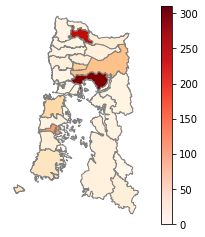

In [6]:
territory = territory_map(10)
lista =[]
n = 20
for comuna in territory["Comuna"]:
    # print(comuna)
    comdata = df[df["comuna"] == comuna.lower()]
    lista.append({"Comuna": comuna, "Valor": comdata.shape[0]})
geodf = pd.DataFrame(lista)

save_map(geodf, territory, "Mapa")

# Análisis LDA

In [7]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [ ]:
start=2
limit=15
step=2

topicmatcher = Matcher(nlp.vocab)
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [ ]:
for comuna in comunas:
    dfcom = df[df["comuna"] == comuna]
    noticias = dfcom["text"]
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)